# In this notebook we will be gathering, assessing, cleaning, analyzing, and visualizing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import json
from functools import reduce
from datetime import datetime

## Gathering data

In [2]:
# load the csv file into a DataFrame
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
img_req = requests.get(url, allow_redirects=True)

open('image_predictions.tsv', 'wb').write(img_req.content)
image_df = pd.read_csv('image_predictions.tsv', sep = '\t')
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [4]:
import os
print(os.getcwd())
arr = os.listdir('.')
print(arr)

/Users/pp/Documents/Udacity/Wrangle_Analyze_Data_Submission_Pankaj_09072020
['wrangle_act.ipynb', 'twitter-archive-enhanced.csv', 'act_report.pdf', 'image_predictions.tsv', 'twitter_archive_master.csv', '.ipynb_checkpoints', 'tweet_json.txt', 'wrangle_report.pdf']


In [5]:
# Loading the Twitter data without creating Twitter account

tweet_json_df = pd.read_json('tweet_json.txt',lines=True)
tweet_json_df["retweeted_status"].fillna("original", inplace = True) 

columns = ['id','favorite_count','retweet_count','retweeted','retweeted_status']#,'retweet_status']

tweet_json = pd.DataFrame(tweet_json_df, columns=columns)
tweet_json = tweet_json.rename(columns = {'id':'tweet_id'}, errors="raise")

tweet_json['original_tweet'] = tweet_json.retweeted_status.apply(lambda x: 'I am original' if x == 'original' else 'I am a retweet')
tweet_json.head(10)
tweet_json.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2354 non-null   int64 
 1   favorite_count    2354 non-null   int64 
 2   retweet_count     2354 non-null   int64 
 3   retweeted         2354 non-null   bool  
 4   retweeted_status  2354 non-null   object
 5   original_tweet    2354 non-null   object
dtypes: bool(1), int64(3), object(2)
memory usage: 94.4+ KB


## Adding twitter_api code as per the feedback from the reviewer.
### Even though I have loaded the twitter data without creating the twitter account, the code is required as part of the submission

### I also found an interesting code to create the dataframe from Twitter search API
https://stackoverflow.com/questions/47612822/how-to-create-pandas-dataframe-from-twitter-search-api


In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'MY_KEY'
consumer_secret = 'MY_SECRET_KEX'
access_token = 'MY_TOKEN'
access_secret = 'MY_SECRET_TOKEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 (archive_df) is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()

print(end - start)
print(fails_dict)

## Gathering Data - Conclusion

><div class="alert alert-success" role="alert"> 
><div class="alert alert-danger" role="alert">
The data has been gathered in three dataframes from three different sources:<br/>
        1. archive_df  from 'twitter-archive-enhanced.csv'<br/>
        2. image_df  from 'image_predictions.tsv'<br/>
        3. tweet_json  from 'tweet_json.txt'. This file contains fields required for analysis<br/>
</div>    
</div>

## Assessing data
### Goal: Identify quality and tidiness issues.<br/> Detect and document at least eight (8) quality issues and two (2) tidiness issues in your wrangle_act.ipynb Jupyter Notebook.


> <div class="alert alert-block alert-success">  <br/>
Cleaning includes merging individual pieces of data according to the rules of tidy data.

In [6]:
archive_df.info()
archive_df.head()

# Issue 1: Missing data for columns in archive_df - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id, retweeted_status_timestamp 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [7]:
image_df.info()
image_df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [8]:
tweet_json.info()
tweet_json.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2354 non-null   int64 
 1   favorite_count    2354 non-null   int64 
 2   retweet_count     2354 non-null   int64 
 3   retweeted         2354 non-null   bool  
 4   retweeted_status  2354 non-null   object
 5   original_tweet    2354 non-null   object
dtypes: bool(1), int64(3), object(2)
memory usage: 94.4+ KB


,tweet_id,favorite_count,retweet_count,retweeted,retweeted_status,original_tweet
0,892420643555336193,39467,8853,False,original,I am original
1,892177421306343426,33819,6514,False,original,I am original
2,891815181378084864,25461,4328,False,original,I am original
3,891689557279858688,42908,8964,False,original,I am original
4,891327558926688256,41048,9774,False,original,I am original


In [9]:
#Check for duplicates

#sum(image_df.jpg_url.duplicated())
print('Duplicates in archive df: ',archive_df.duplicated().sum())
print('Duplicates in image df: ',image_df.duplicated().sum())
#print('Duplicates in tweet df: ',tweet_json.duplicated().sum())

print('Duplicates in archive df for tweet id: ',archive_df['tweet_id'].duplicated().sum())
print('Duplicates in image df for tweet id: ',image_df['tweet_id'].duplicated().sum())
print('Duplicates in tweet df for tweet id: ',tweet_json['tweet_id'].duplicated().sum())

Duplicates in archive df:  0
Duplicates in image df:  0
Duplicates in archive df for tweet id:  0
Duplicates in image df for tweet id:  0
Duplicates in tweet df for tweet id:  0


In [10]:
# Check for NULL values
archive_df.isnull().sum()
#same as Issue # 1

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [11]:
image_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [12]:
tweet_json.isnull().sum()

tweet_id            0
favorite_count      0
retweet_count       0
retweeted           0
retweeted_status    0
original_tweet      0
dtype: int64

In [13]:
# Deep dive into each of the data sets
#archive_df.info()
archive_df['name'].value_counts()
#Issue 2: There are names such as 'None', 'a', 'such','O','a', 'actually', 'all', 'an', 
#       'the', 'this', 'unacceptable', 'very','my', 'not', 'officially', 'by', 'getting',
#      'his'
#np.sort(archive_df['name'].unique())
#archive_df.query("name == 'an'").loc[:,['text','name']]
#Issue # 3: Most of the names starts with Caps 
#while there are few at the end starting with small letter


None       745
a           55
Charlie     12
Cooper      11
Oliver      11
          ... 
Mike         1
Pippin       1
Petrick      1
Noosh        1
Dex          1
Name: name, Length: 957, dtype: int64

In [14]:
archive_df.info()
archive_df.head()
print(np.sort(archive_df['doggo'].unique()))
print(np.sort(archive_df['floofer'].unique()))
print(np.sort(archive_df['pupper'].unique()))
print(np.sort(archive_df['puppo'].unique()))

print(archive_df['doggo'].value_counts())
print(archive_df['floofer'].value_counts())
print(archive_df['pupper'].value_counts())
print(archive_df['puppo'].value_counts())

#find records with none of the columns populated with correct value
archive_df.loc[(archive_df['doggo']== 'None') & (archive_df['floofer']== 'None') & (archive_df['pupper']== 'None') & (archive_df['puppo']== 'None')]


#Issue # 3: The four columns, doggo, floofer, pupper and puppo has all the values
#populated as None for 1976/2356 records, so there is no dog "stage" (i.e. doggo, floofer, pupper, and puppo) information


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [15]:
# analyze rating numerator and denominator
print(np.sort(archive_df['rating_numerator'].unique()))
print(archive_df['rating_numerator'].value_counts())


#Issue 4: Rating numerator is 1776 for one record and 0 for two records


[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   17   20   24   26   27   44   45   50   60   75   80   84
   88   99  121  143  144  165  182  204  420  666  960 1776]
12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64


In [16]:
# analyze rating numerator and denominator
print(np.sort(archive_df['rating_denominator'].unique()))
print(archive_df['rating_denominator'].value_counts())

#Issue 4: Rating denominator is expected to be 10 but there are other value too

[  0   2   7  10  11  15  16  20  40  50  70  80  90 110 120 130 150 170]
10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64


In [17]:
#You only want original ratings (no retweets) that have images. 
#Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.

#analyze retweet data
print("Total retweets:",archive_df.shape)
#print("Not a Retweet",archive_df['retweeted_status_id'].isnull().sum())
count_null = archive_df['retweeted_status_id'].isnull().sum()
print ('Original Tweets (retweet ID as NULL): ' + str(count_null))
print("Total retweets:",archive_df.shape[0] - count_null)

#Issue 5: We are not intrested in retweets and there are 181 retweets in the archive data

Total retweets: (2356, 17)
Original Tweets (retweet ID as NULL): 2175
Total retweets: 181


In [18]:
# lets analyze images data
image_df.head()


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [19]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
image_df.isnull().sum()
# No null values

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [21]:
image_df['tweet_id'].duplicated().any()
# No duplicates for tweet id


False

In [22]:
print('------p1_dog-----\n',image_df['p1_dog'].value_counts())
print('------p2_dog-----\n',image_df['p2_dog'].value_counts())
print('------p3_dog-----\n',image_df['p3_dog'].value_counts())

#print(image_df.loc[(image_df['p1_dog']== False) & (image_df['p2_dog']== False) & (image_df['p3_dog']== False)])

not_a_dog = image_df.loc[(image_df['p1_dog']== False) & (image_df['p2_dog']== False) & (image_df['p3_dog']== False)] 
print('------not_a_dog----\n',not_a_dog['tweet_id'].value_counts())

# Issue 6: There are 324 records for which all three algorithm predeictions is other than 
# the dog breed
# We could saave time by removing these records

------p1_dog-----
 True     1532
False     543
Name: p1_dog, dtype: int64
------p2_dog-----
 True     1553
False     522
Name: p2_dog, dtype: int64
------p3_dog-----
 True     1499
False     576
Name: p3_dog, dtype: int64
------not_a_dog----
 669972011175813120    1
690248561355657216    1
674754018082705410    1
694905863685980160    1
668988183816871936    1
                     ..
672231046314901505    1
670361874861563904    1
671497587707535361    1
666051853826850816    1
671511350426865664    1
Name: tweet_id, Length: 324, dtype: int64


In [23]:
image_df.head()
#print('------image num-----\n',image_df['img_num'].value_counts())

# Issue 7: The dog breed names populated in the p1, p2 and p2 are not consistent
#few are starting with CAPS while others are with lowercase

# Issue 8: There are multiple dog breeds in one column with underscore as delimiter
# we may want to consider one for analysis


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [24]:
# check for duplicates in the url
image_df['jpg_url'].duplicated().any()

print('Duplicates URLs: ',image_df['jpg_url'].duplicated().sum())

# Issue 9: There are 66 duplciate URLS, which means same pic has been uploaded which
# will not provide additional information and we may want to delete the duplicate pics


Duplicates URLs:  66


In [25]:
# Analyze the lst file 

In [26]:
#tweet_json.head()
#tweet_json.info()
tweet_json.head(10)



,tweet_id,favorite_count,retweet_count,retweeted,retweeted_status,original_tweet
0,892420643555336193,39467,8853,False,original,I am original
1,892177421306343426,33819,6514,False,original,I am original
2,891815181378084864,25461,4328,False,original,I am original
3,891689557279858688,42908,8964,False,original,I am original
4,891327558926688256,41048,9774,False,original,I am original
5,891087950875897856,20562,3261,False,original,I am original
6,890971913173991426,12041,2158,False,original,I am original
7,890729181411237888,56848,16716,False,original,I am original
8,890609185150312448,28226,4429,False,original,I am original
9,890240255349198849,32467,7711,False,original,I am original


In [27]:
tweet_json.isnull().sum()
# no NULL values

tweet_id            0
favorite_count      0
retweet_count       0
retweeted           0
retweeted_status    0
original_tweet      0
dtype: int64

In [28]:
tweet_json['tweet_id'].duplicated().any()
# No duplicates for tweet id

False

In [29]:
tweet_json.retweeted.value_counts()
# All the values for 'retweeted' column is False, hence we may want to use retweeted_status
# for further analysis

False    2354
Name: retweeted, dtype: int64

In [30]:
tweet_json.original_tweet.value_counts()

#Issue 10: We only want original ratings (no retweets), hence 179 retweets can be deleted

I am original     2175
I am a retweet     179
Name: original_tweet, dtype: int64

In [31]:
tweet_json.head()

,tweet_id,favorite_count,retweet_count,retweeted,retweeted_status,original_tweet
0,892420643555336193,39467,8853,False,original,I am original
1,892177421306343426,33819,6514,False,original,I am original
2,891815181378084864,25461,4328,False,original,I am original
3,891689557279858688,42908,8964,False,original,I am original
4,891327558926688256,41048,9774,False,original,I am original


In [32]:
tweet_json.dtypes

tweet_id             int64
favorite_count       int64
retweet_count        int64
retweeted             bool
retweeted_status    object
original_tweet      object
dtype: object

## Assessing Data - Conclusion

><div class="alert alert-success" role="alert"> 
><div class="alert alert-danger" role="alert">
 After analyzing the shape and underline data in the three dataframes, below are the Data Quality and Tidiness recommendations: <br/>
    <br/>
    <b> Data Quality </b><br/><br/>
    1. Missing data for columns in archive_df - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp. It could be due to retweets, which can be deleted <br/>
    2.  There are names such as 'None', 'a', 'such','O','a', 'actually', 'all', 'an', 'the', 'this', 'unacceptable', 'very','my', 'not', 'officially', 'by', 'getting', 'his'<br/>
    3.  Most of the names starts with Caps while there are few at the end starting with small letter<br/>
    4.  The four columns, doggo, floofer, pupper and puppo has all the values populated as None for 1976/2356 records, so there is no dog "stage" (i.e. doggo, floofer, pupper, and puppo) information<br/>
    5. Rating numerator is 1776 for one record and 0 for two records<br/>
    6. Rating denominator is expected to be 10 but there are other value too<br/>
    7. We are not interested in retweets and there are 181 retweets in the archive data<br/>
    8. There are 324 records for which all three algorithm predeictions is other than the dog breed. We could save time by removing these records<br/>
    9. The dog breed names populated in the p1, p2 and p2 are not consistent few are starting with CAPS while others are with lowercase<br/>
    10. There are 66 duplciate URLS, which means same pic has been uploaded which will not provide additional information and we may want to delete the duplicate pics<br/>
    11. We only want original ratings (no retweets), hence 179 retweets can be deleted from twee_json dataframe<br/><br/><br/>
    <b> Data Tidiness </b><br/><br/>
    1. In the archive dataframe, the dog "stage" information (i.e. doggo, floofer, pupper, and puppo) is scattered in four columns and can be merged under one column<br/>
    2. In images file, there are three columns with prediction and prediction confidence information. Most of the time p1>p2>p3, hence can be combined under one column <br/>
    3. Merge the three dataframes and bring only required fields in the final dataframe
<br/>  
</div>   
</div>

# Data Cleaning

In [33]:
# create copy for future reference
archive_dc = archive_df.copy()
images_dc = image_df.copy()
tweet_json_dc = tweet_json.copy()

print(archive_dc.shape)
print(images_dc.shape)
print(tweet_json_dc.shape)

(2356, 17)
(2075, 12)
(2354, 6)


## Cleaning archive_df dataframe

In [34]:
# Define: combine the dog stage columns into one
archive_dc = archive_df.copy()

dog_stage = ['doggo', 'floofer', 'pupper', 'puppo']
req_cols = [x for x in archive_dc.columns.tolist() if x not in dog_stage]

print('Duplicates in archive dc BEFORE melt: ',archive_dc['tweet_id'].duplicated().sum())
print('--- archive dc shape BEFORE melt------',archive_dc.shape)

#CODE: melt the doggo, floofer, pupper and puppo columns to all_stages and dog_stage column
archive_dc = pd.melt(archive_dc, id_vars = req_cols, value_vars = dog_stage, var_name = 'all_stages', value_name = 'dog_stage')

#Test before making the changes:
print('Duplicates in archive df AFTER melt: ',archive_dc['tweet_id'].duplicated().sum())
print('--- archive dc shape AFTER melt------',archive_dc.shape)
print('--- Dog stages AFTER melt------]n',archive_dc['dog_stage'].value_counts())
# Code: delete column 'all_stages'
archive_dc = archive_dc.drop('all_stages', 1)
# Code: drop duplicates based on tweet_id except the last occurrence, after the sort
archive_dc = archive_dc.sort_values('dog_stage').drop_duplicates(subset='tweet_id',keep='last')

#Test:
print('--- archive dc shape AFTER removing duplicates------',archive_dc.shape)
print('--- Dog stages AFTER melt and after removing duplicates------\n',archive_dc['dog_stage'].value_counts())

archive_dc.info()


Duplicates in archive dc BEFORE melt:  0
--- archive dc shape BEFORE melt------ (2356, 17)
Duplicates in archive df AFTER melt:  7068
--- archive dc shape AFTER melt------ (9424, 15)
--- Dog stages AFTER melt------]n None       9030
pupper      257
doggo        97
puppo        30
floofer      10
Name: dog_stage, dtype: int64
--- archive dc shape AFTER removing duplicates------ (2356, 14)
--- Dog stages AFTER melt and after removing duplicates------
 None       1976
pupper      257
doggo        83
puppo        30
floofer      10
Name: dog_stage, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2259 to 7236
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non

In [35]:
# 2nd copy
archive_dc2 = archive_dc.copy()

# Define: As we are only interested in the original tweets, 
#remove the records where retweet_status_id is populated

#Test: print('--- Test BEFORE------\n',archive_dc2.info())
archive_dc2['retweeted_status_id'].head()
print('----Value count BEFORE removing NULL values ---\n',sum(archive_dc2['retweeted_status_id'].value_counts()))

#Code: delete retweets by filtering the NULL values from retweeted_status_id
archive_dc2 = archive_dc2[pd.isnull(archive_dc2['retweeted_status_id'])]

#Test: 
print('--- Test AFTER------\n',archive_dc2.info())
archive_dc2['retweeted_status_id'].head()
print('----Value count AFTER removing NULL values ---\n',sum(archive_dc2['retweeted_status_id'].value_counts()))

#181 records are dropped 

----Value count BEFORE removing NULL values ---
 181
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 2261 to 7236
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 n

In [36]:

# Define: Get names of indexes for which column rating_denominator'!=10
indexNames = archive_dc2[ archive_dc2['rating_denominator']!=10].index
#print(indexNames)
print('--- archive dc shape BEFORE removing the records------',archive_dc2.shape)

# Code: Delete these row indexes from dataFrame
archive_dc2.drop(indexNames , inplace=True)

#Test:
print('--- archive dc shape AFTER removing the records------',archive_dc2.shape)

--- archive dc shape BEFORE removing the records------ (2175, 14)
--- archive dc shape AFTER removing the records------ (2153, 14)


In [37]:
# Define: update the numerator

print('--total incorrect records---:',archive_dc2['rating_numerator'].isnull().sum())
archive_dc2['rating_numerator'].value_counts()
columns = ['tweet_id', 'text', 'rating_numerator', 'rating_denominator']

# text column also contains a part of rating
# extract tweets with decimals and found that rating_numerator is not populated corectly
# Code: to convert numerator as denominator to float

archive_dc2['rating_numerator'] = archive_dc2['rating_numerator'].astype(float)
archive_dc2['rating_denominator'] = archive_dc2['rating_denominator'].astype(float)

print(archive_dc2.info())

with pd.option_context('max_colwidth', 200):
    display(archive_dc2[archive_dc2['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [columns].head(40))

# Code: now either I can fix this or delte the records, I decide to fix as these are only three

archive_dc2.loc[(archive_dc2['tweet_id'] == 883482846933004288) & (archive_dc2['rating_numerator'] == 5), ['rating_numerator']] = 13.5
archive_dc2.loc[(archive_dc2['tweet_id'] == 786709082849828864) & (archive_dc2['rating_numerator'] == 75), ['rating_numerator']] = 9.75
archive_dc2.loc[(archive_dc2['tweet_id'] == 778027034220126208) & (archive_dc2['rating_numerator'] == 27), ['rating_numerator']] = 11.27
archive_dc2.loc[(archive_dc2['tweet_id'] == 681340665377193984) & (archive_dc2['rating_numerator'] == 5), ['rating_numerator']] = 9.5
archive_dc2.loc[(archive_dc2['tweet_id'] == 680494726643068929) & (archive_dc2['rating_numerator'] == 26), ['rating_numerator']] = 11.26

# Test: 
print('----AFTER fix----\n\n')
with pd.option_context('max_colwidth', 200):
    display(archive_dc2[archive_dc2['text'].str.contains(r"(\d+\.\d*\/\d+)")]
            [columns].head(40))

--total incorrect records---: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 2261 to 7236
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2153 non-null   int64  
 1   in_reply_to_status_id       73 non-null     float64
 2   in_reply_to_user_id         73 non-null     float64
 3   timestamp                   2153 non-null   object 
 4   source                      2153 non-null   object 
 5   text                        2153 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2099 non-null   object 
 10  rating_numerator            2153 non-null   float64
 11  rating_denominator          2153 non-null   float64
 12  name                        2153 non-null   object 
 13

/Users/pp/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0,10.0
4068,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0,10.0
4045,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5.0,10.0
3051,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0,10.0
5475,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27.0,10.0


----AFTER fix----




/Users/pp/opt/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,text,rating_numerator,rating_denominator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0
4068,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0
4045,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,9.50,10.0
3051,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0
5475,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0


In [38]:
# Define: To analyze the tweets for a month and year, timestamp should be datetime

#Code:
archive_dc2['timestamp'] = pd.to_datetime(archive_dc2['timestamp'])

#Test: The data type of the timestamp is now datetime64
archive_dc2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 2261 to 7236
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2153 non-null   int64              
 1   in_reply_to_status_id       73 non-null     float64            
 2   in_reply_to_user_id         73 non-null     float64            
 3   timestamp                   2153 non-null   datetime64[ns, UTC]
 4   source                      2153 non-null   object             
 5   text                        2153 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2099 non-null   object             
 10  rating_numerator            2153 non-null   float64      

In [39]:
# 3rd copy
archive_final = archive_dc2.copy()

# Define: clean up the data with incorrect names. Let's start with names in lower case
names = []
for row in archive_final['name']:
    if row[0].islower() and row not in names:
        names.append(row)
print(names)

# Code: All these names seems incorrect, hence replace them with NaN and then drop the records
archive_final['name'].replace(names, np.NaN, inplace = True)
print('--- archive dc shape BEFORE removing the records------',archive_final.shape)

# 664 records are names as None

#Code: replace None with NaN
archive_final['name'].replace('None', np.NaN, inplace = True)

#Test:
print('--Different values after replacement---:\n',archive_final['name'].value_counts())
print('--total incorrect names---:',archive_final['name'].isnull().sum())
archive_final.info()

['a', 'the', 'an', 'quite', 'such', 'getting', 'very', 'unacceptable', 'old', 'infuriating', 'just', 'light', 'space', 'by', 'officially', 'actually', 'life', 'incredibly', 'not', 'one', 'my', 'his', 'mad', 'all']
--- archive dc shape BEFORE removing the records------ (2153, 14)
--Different values after replacement---:
 Lucy        11
Charlie     11
Oliver      10
Cooper      10
Tucker       9
            ..
Vinscent     1
Barry        1
Rodney       1
Pippin       1
Apollo       1
Name: name, Length: 928, dtype: int64
--total incorrect names---: 765
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 2261 to 7236
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2153 non-null   int64              
 1   in_reply_to_status_id       73 non-null     float64            
 2   in_reply_to_user_id         73 non-null     float64 

In [40]:
#Define: remove extra columns

#Code:
drop_extra = ['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 
           'retweeted_status_user_id', 'retweeted_status_timestamp','expanded_urls']
print('--- image dc shape BEFORE dropping the columns------',archive_final.shape)
#Code:
archive_final.drop(drop_extra, axis =1, inplace=True)

#Test:
print('--- image dc shape BEFORE dropping the columns------',archive_final.shape)

--- image dc shape BEFORE dropping the columns------ (2153, 14)
--- image dc shape BEFORE dropping the columns------ (2153, 8)


## Cleaning Image dataframe


In [41]:
#create copy
images_dc2 = images_dc.copy()

# Define: There are 66 records with same url, which means duplicate pictures are submitted or 
# duplicate pic has been uploaded again, hence delete the record with duplicated jpg_url
print('----- BEFORE dropping duplicates------ :',
      sum(images_dc2['jpg_url'].duplicated()))

#Code:
images_dc2 = images_dc2.drop_duplicates(subset=['jpg_url'], keep='last')


#Test:
print('----- AFTER dropping duplicates------ :',
      sum(images_dc2['jpg_url'].duplicated()))
images_dc.head()



----- BEFORE dropping duplicates------ : 66
----- AFTER dropping duplicates------ : 0


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [42]:
# Define: There are three columns for prediction and prediction confidence
# which can be merged into single column for each

#Code: Create function to populate the value from one of the three columns
def dog_breed(row):
    if row['p1_dog']:
        return(row['p1'])
    elif row['p2_dog']:
        return(row['p2'])
    elif row['p3_dog']:
        return(row['p3'])
    else:
        return(np.NaN)
def dog_conf(row):
    if row['p1_dog']:
        return(row['p1_conf'])
    elif row['p2_dog']:
        return(row['p2_conf'])
    elif row['p3_dog']:
        return(row['p3_conf'])
    else:
        return(np.NaN)

In [43]:
# create 3rd copy
images_dc3 = images_dc2.copy()

# Define: Create new column for prediction and prediction confidence
# and drop the existing columns

#Code:
images_dc3['dog_breed'] = images_dc3.apply (lambda row: dog_breed(row),axis=1)
images_dc3['dog_conf'] = images_dc3.apply (lambda row: dog_conf(row),axis=1)
print('--- image dc shape BEFORE dropping the columns------',images_dc3.shape)

#Code:
drop_columns = ['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog','img_num']
images_dc3.drop(drop_columns, axis =1, inplace=True)

#Test:
print('--- image dc shape BEFORE dropping the columns------',images_dc3.shape)
images_dc3[images_dc3['dog_breed'].isnull()].head()


--- image dc shape BEFORE dropping the columns------ (2009, 14)
--- image dc shape BEFORE dropping the columns------ (2009, 4)


,tweet_id,jpg_url,dog_breed,dog_conf
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,NaN,NaN
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,NaN,NaN
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,NaN,NaN
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,NaN,NaN
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,NaN,NaN


In [44]:
# create copy
images_final = images_dc3.copy()

print('--- image dc shape BEFORE dropping the records with no value in dog breed------'
      ,images_final.shape)
images_final = images_dc3.dropna(subset=['dog_breed'])
print('--dog breed with no value---:',images_final['dog_breed'].isnull().sum())
#images_final[images_final['dog_breed'].isnull()].head()
print('--- image dc shape AFTER dropping the records with no value in dog breed------'
      ,images_final.shape)

# Define: update the dog breed to lower case to keep it consistent

#Code:
images_final['dog_breed'] = images_final['dog_breed'].str.lower()

#Test:
images_final.head()

--- image dc shape BEFORE dropping the records with no value in dog breed------ (2009, 4)
--dog breed with no value---: 0
--- image dc shape AFTER dropping the records with no value in dog breed------ (1691, 4)


/Users/pp/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,tweet_id,jpg_url,dog_breed,dog_conf
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,german_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311


## Cleaning json dataframe


In [45]:
tweet_json_dc.head()
tweet_json_dc['original_tweet'].value_counts()

#create copy
json_final = tweet_json_dc.copy()

# Define: Remove the records with retweets

# Code: Delete these row indexes from dataFrame
indexNames = json_final[ json_final['original_tweet'] == 'I am a retweet'].index
print('--- archive dc shape BEFORE removing the records------',json_final.shape)
json_final.drop(indexNames , inplace=True)

#Test:
print('--- archive dc shape AFTER removing the records------',json_final.shape)

--- archive dc shape BEFORE removing the records------ (2354, 6)
--- archive dc shape AFTER removing the records------ (2175, 6)


In [46]:
#Define: merge the datasets as all can be linked with tweet_id

#BeforeMerge:
print('---Before Merge----\n')
print(archive_final.shape)
print(images_final.shape)
print(json_final.shape)

#Code:
data_frames = [archive_final, images_final, json_final]
twitter_archive_master = reduce(lambda left, right:  pd.merge(left, right, on = 'tweet_id'),data_frames)

#Test:
print('---After Merge----\n')
twitter_archive_master.shape
#twitter_archive_master.info()

---Before Merge----

(2153, 8)
(1691, 4)
(2175, 6)
---After Merge----



(1609, 16)

## Cleaning Data - Conclusion

<div class="alert alert-success" role="alert"> 
<div class="alert alert-danger" role="alert">    
<br/>
<b> Data Quality </b><br/><br/>
    1. Missing data for columns in archive_df - in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp. It could be due to retweets, which can be deleted <b>--DONE </b> <br/> 
    2.  There are names such as 'None', 'a', 'such','O','a', 'actually', 'all', 'an', 'the', 'this', 'unacceptable', 'very','my', 'not', 'officially', 'by', 'getting', 'his'<b>--DONE </b><br/>
    3.  Most of the names starts with Caps while there are few at the end starting with small letter<b>--DONE </b><br/>
    4.  The four columns, doggo, floofer, pupper and puppo has all the values populated as None for 1976/2356 records, so there is no dog "stage" (i.e. doggo, floofer, pupper, and puppo) information<b>--DONE </b>  <br/> 
    5. Rating numerator is 1776 for one record and 0 for two records<b>--DONE </b><br/>
    6. Rating denominator is expected to be 10 but there are other value too<b>--DONE </b>  <br/> 
    7. We are not interested in retweets and there are 181 retweets in the archive data<b>--DONE </b><br/>
    8. There are 324 records for which all three algorithm predictions is other than the dog breed. We could save time by removing these records<b>--DONE</b><br/>
    9. The dog breed names populated in the p1, p2 and p2 are not consistent few are starting with CAPS while others are with lowercase<b>--DONE</b><br/>
    10. There are 66 duplciate URLS, which means same pic has been uploaded which will not provide additional information and we may want to delete the duplicate pics<b>--DONE </b><br/>
    11. We only want original ratings (no retweets), hence 179 retweets can be deleted from twee_json dataframe<br/><br/><br/>
    <b> Data Tidiness </b><br/><br/>
    1. In the archive dataframe, the dog "stage" information (i.e. doggo, floofer, pupper, and puppo) is scattered in four columns and can be merged under one column<b>--DONE </b><br/>
    2. In images file, there are three columns with prediction and prediction confidence information. Most of the time p1>p2>p3, hence can be combined under one column <b>--DONE </b><br/>
    3. Merge the three dataframes and bring only required fields in the final dataframe <b>--DONE </b> 
</div> 
</div>

### References: 
https://realpython.com/python-reduce-function/

https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes/44338256

https://stackoverflow.com/questions/51519101/simultaneously-melt-multiple-columns-in-python-pandas

https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html



# Storing data

In [47]:
twitter_archive_master.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)
print(' ----   *** successfully stored *** ----')

 ----   *** successfully stored *** ----


# Analyzing and Visualizing data
##  three (3) insights and one (1) visualization 

In [48]:
# import additional packages for interactive plotting 
import seaborn as sns



In [49]:
analyze_df = pd.read_csv('twitter_archive_master.csv')
analyze_df.shape
sns.set_style("whitegrid")


#analyze_df.info()
analyze_df.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stage,jpg_url,dog_breed,dog_conf,favorite_count,retweet_count,retweeted,retweeted_status,original_tweet
0,667546741521195010,2015-11-20 03:35:20+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Here is George. George took a selfie of his ne...,9.0,10.0,George,None,https://pbs.twimg.com/media/CUOaOWXWcAA0_Jy.jpg,toy_poodle,0.787424,355,138,False,original,I am original
1,667544320556335104,2015-11-20 03:25:43+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Kial. Kial is either wearing a cape, w...",10.0,10.0,Kial,None,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,pomeranian,0.412893,917,568,False,original,I am original
2,667538891197542400,2015-11-20 03:04:08+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This is a southwest Coriander named Klint. Hat...,9.0,10.0,NaN,None,https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg,yorkshire_terrier,0.618957,220,72,False,original,I am original
3,667534815156183040,2015-11-20 02:47:56+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Frank (pronounced ""Fronq""). Too many b...",8.0,10.0,Frank,None,https://pbs.twimg.com/media/CUOPYI5UcAAj_nO.jpg,pembroke,0.435254,866,576,False,original,I am original
4,667524857454854144,2015-11-20 02:08:22+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Another topnotch dog. His name is Big Jumpy Ra...,12.0,10.0,NaN,None,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,chesapeake_bay_retriever,0.088122,1798,1198,False,original,I am original


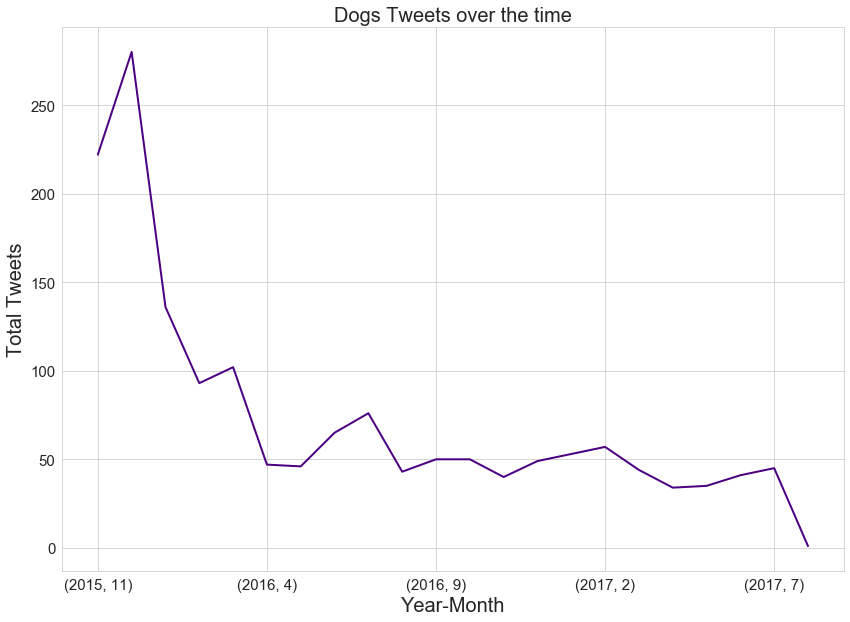

<Figure size 432x288 with 0 Axes>

In [50]:
# plot no. of tweets over the time
analyze_df['timestamp'] = pd.to_datetime(analyze_df['timestamp'])
analyze_df['timestamp'].apply(lambda x: x.strftime('%Y-%m')).value_counts().sort_index()
#analyze_df.info()

tweets = analyze_df['tweet_id'].groupby([analyze_df['timestamp'].dt.year, analyze_df['timestamp'].dt.month]).count()
tweets.plot(kind = 'line',figsize = (14,10),fontsize=15,color = '#4b0082', linewidth=2)
#tweets.sort_values(ascending = False).plot(kind= 'line',figsize = (12,12),fontsize=15,color = '#4b0082', linewidth=3)
# for purple - color = '#4b0082'
plt.ylabel('Total Tweets' , fontsize = 20)
plt.xlabel('Year-Month' , fontsize = 20)
plt.title('Dogs Tweets over the time',fontsize = 20)
plt.show()
plt.savefig('Dogs Tweets over the time')


### Conclusion of the line graph

><div class="alert alert-success" role="alert"> 
><div class="alert alert-danger" role="alert">    
The number of tweets has decreased significantly in last two years <br/>
The maximum number of tweets, 288 were received in Dec 2015 and minimum tweets, 34 has been posted in Apr 2017 <br/>
The line fraph shows constant value of 50 tweet from Apr 2016<br/>   
</div>   
</div>

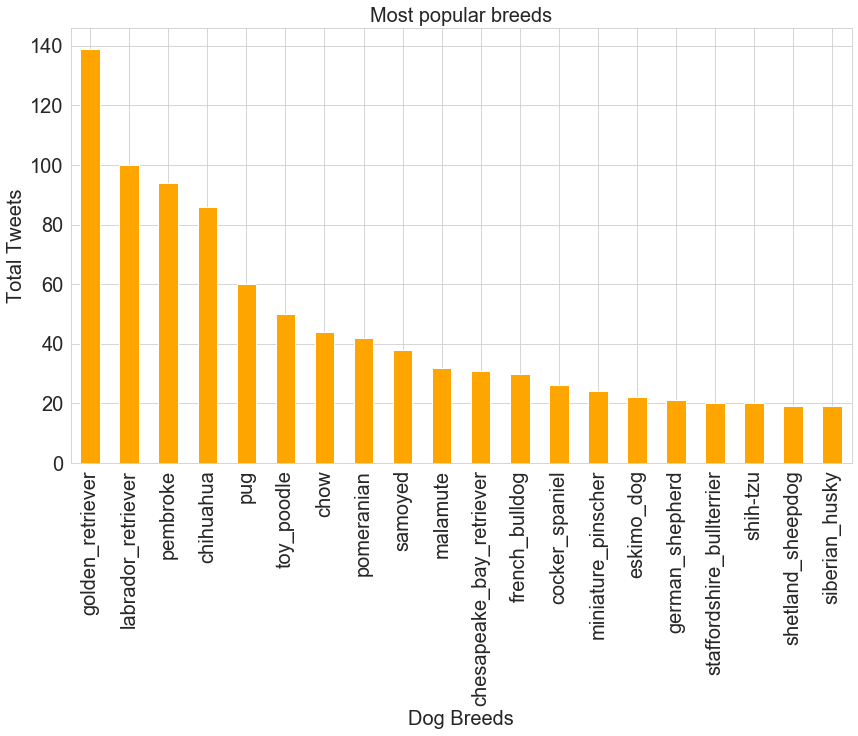

['golden_retriever',
 'labrador_retriever',
 'pembroke',
 'chihuahua',
 'pug',
 'toy_poodle',
 'chow',
 'pomeranian',
 'samoyed',
 'malamute',
 'chesapeake_bay_retriever',
 'french_bulldog',
 'cocker_spaniel',
 'miniature_pinscher',
 'eskimo_dog',
 'german_shepherd',
 'shih-tzu',
 'staffordshire_bullterrier',
 'shetland_sheepdog',
 'siberian_husky']

<Figure size 432x288 with 0 Axes>

In [51]:
# Top 20 popular dog breed
top20_breeds = analyze_df['dog_breed'].value_counts()[0:20].index.tolist()
top20_breeds
#dog_breed = analyze_df[analyze_df['dog_breed'].isin(top20_breeds)].groupby('dog_breed').value_counts().reset_index(name = 'counts').copy()  
#print(dog_breed)

dog_breed = analyze_df[analyze_df['dog_breed'].isin(top20_breeds)].groupby('dog_breed').count()['tweet_id'].copy()

dog_breed.sort_values(ascending = False).plot(kind = 'bar',figsize = (14,8),fontsize=20,color = 'orange')

plt.ylabel('Total Tweets' , fontsize = 20)
plt.xlabel('Dog Breeds' , fontsize = 20)
plt.title('Most popular breeds',fontsize = 20)
plt.show()
plt.savefig('Most popular breeds')

top20_breeds



### Conclusion of the bar graph

><div class="alert alert-success" role="alert"> 
><div class="alert alert-danger" role="alert">    
The top 5 popular dog breeds are:<br/>
     'golden_retriever',<br/>
     'labrador_retriever',<br/>
     'pembroke',<br/>
     'chihuahua',<br/>
     'pug',<br/>       
</div>    
</div>

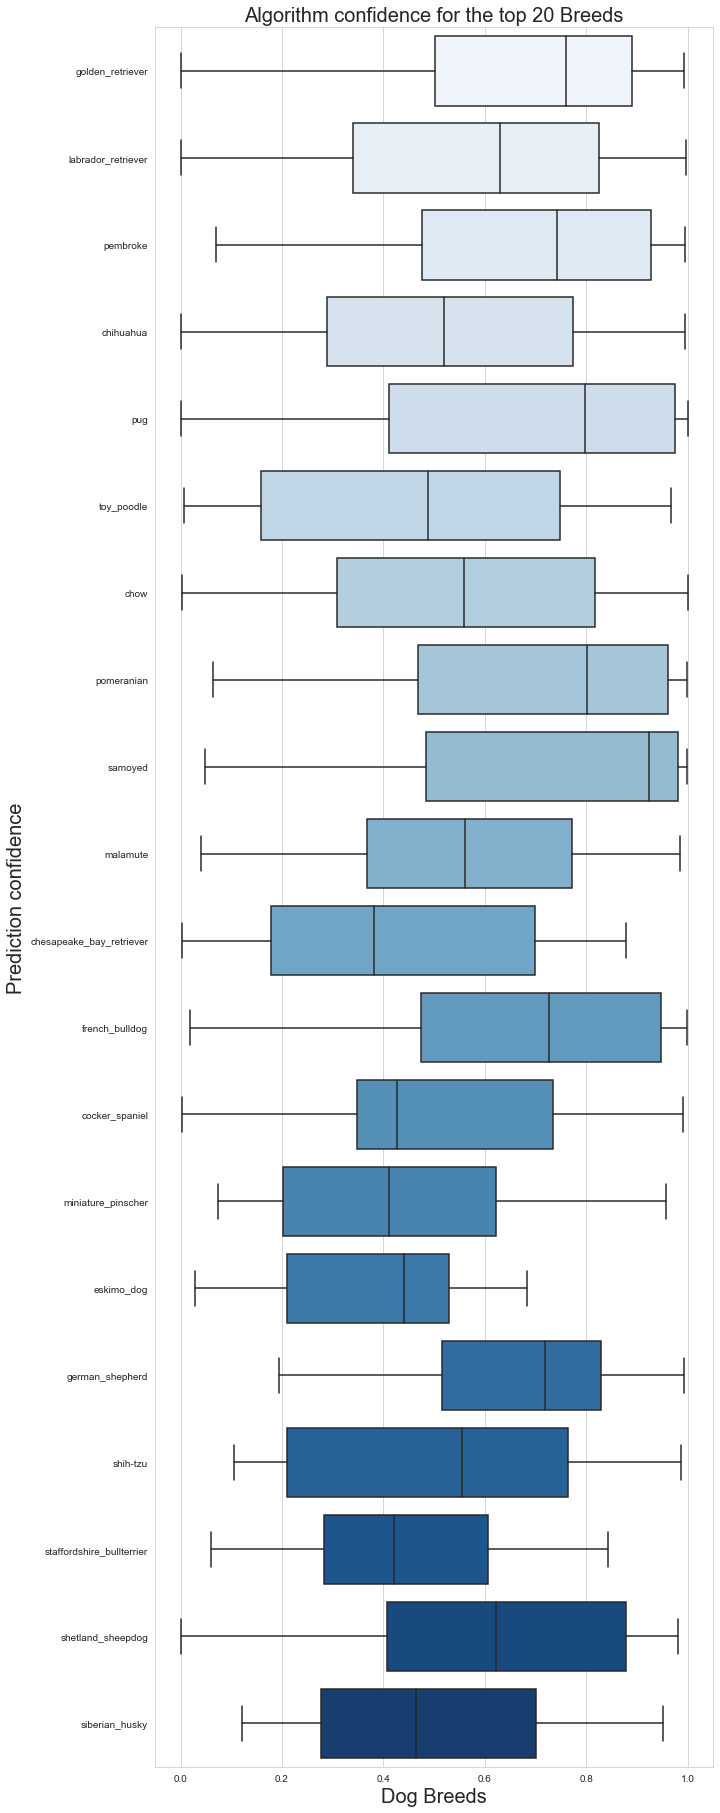

<Figure size 432x288 with 0 Axes>

In [52]:


dog_breed_conf = analyze_df[analyze_df['dog_breed'].isin(top20_breeds)]

# we will try box plot for analyzing prediction confidence
fig,ax = plt.subplots(figsize=(10,32))
sns.set(font_scale=2.5)


sns.boxplot(x='dog_conf', y='dog_breed', data=dog_breed_conf, order=top20_breeds, palette='Blues')  
plt.ylabel('Prediction confidence' , fontsize = 20)
plt.xlabel('Dog Breeds' , fontsize = 20)
plt.title('Algorithm confidence for the top 20 Breeds',fontsize = 20)
#ax.plot(x, y, marker='s', linestyle='none', label='big')
plt.show()
plt.savefig('Algorithm confidence for the top 20 Breeds')

### Conclusion of the bar graph

><div class="alert alert-success" role="alert"> 
><div class="alert alert-danger" role="alert">    
>  The algorithm prediction works well with the breeds with higher median. For example - samoyed, pomeranian <br/>
>  The algorithm prediction didn't provide a great prediction for breeds like chesapeake_bay_retriever and toy_poodle <br/>      
</div>   
</div>

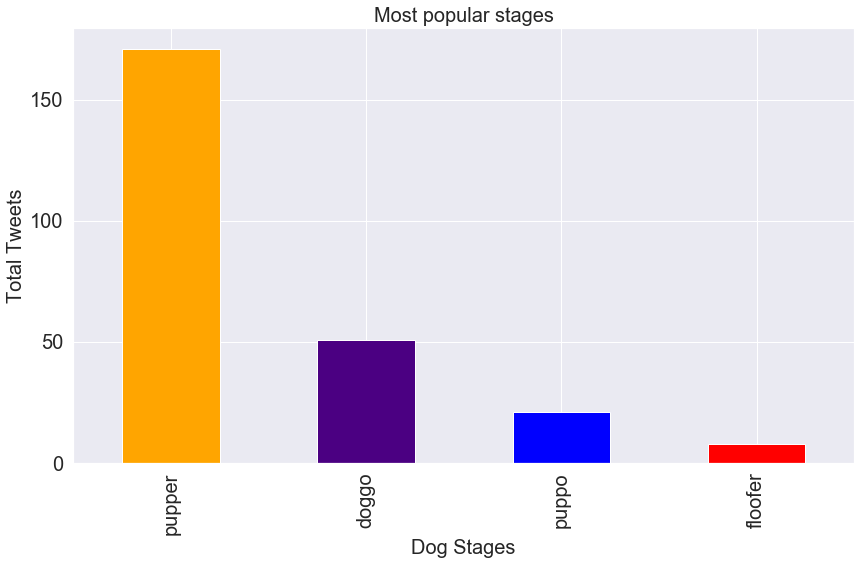

['golden_retriever',
 'labrador_retriever',
 'pembroke',
 'chihuahua',
 'pug',
 'toy_poodle',
 'chow',
 'pomeranian',
 'samoyed',
 'malamute',
 'chesapeake_bay_retriever',
 'french_bulldog',
 'cocker_spaniel',
 'miniature_pinscher',
 'eskimo_dog',
 'german_shepherd',
 'shih-tzu',
 'staffordshire_bullterrier',
 'shetland_sheepdog',
 'siberian_husky']

<Figure size 432x288 with 0 Axes>

In [53]:
# Most popular dog stages
dog_stage = ['doggo', 'floofer', 'pupper', 'puppo']

dog_stage = analyze_df[analyze_df['dog_stage'].isin(dog_stage)].groupby('dog_stage').count()['tweet_id'].copy()

dog_stage.sort_values(ascending = False).plot(kind = 'bar',figsize = (14,8),fontsize=20,color=['orange','#4b0082', 'blue', 'red'])  

plt.ylabel('Total Tweets' , fontsize = 20)
plt.xlabel('Dog Stages' , fontsize = 20)
plt.title('Most popular stages',fontsize = 20)
plt.show()
plt.savefig('Most popular stages')

top20_breeds




### Conclusion of the bar graph

><div class="alert alert-success" role="alert"> 
><div class="alert alert-danger" role="alert">    
Pupper is the most popular dog stage and floofer is the least<br/>      
</div>   
</div>

In [54]:
analyze_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1609 entries, 0 to 1608
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1609 non-null   int64              
 1   timestamp           1609 non-null   datetime64[ns, UTC]
 2   source              1609 non-null   object             
 3   text                1609 non-null   object             
 4   rating_numerator    1609 non-null   float64            
 5   rating_denominator  1609 non-null   float64            
 6   name                1140 non-null   object             
 7   dog_stage           1609 non-null   object             
 8   jpg_url             1609 non-null   object             
 9   dog_breed           1609 non-null   object             
 10  dog_conf            1609 non-null   float64            
 11  favorite_count      1609 non-null   int64              
 12  retweet_count       1609 non-null 

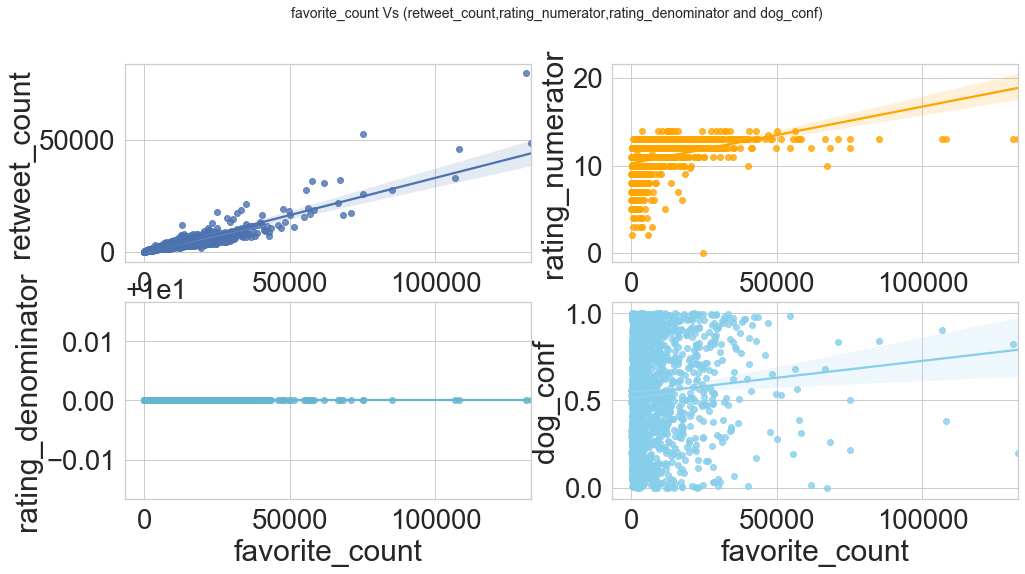

In [55]:
# Analyze relation between key variables 
sns.set_style("whitegrid")
fig, axes = plt.subplots(2,2,figsize = (16,8))
fig.suptitle("favorite_count Vs (retweet_count,rating_numerator,rating_denominator and dog_conf)",fontsize=14)

sns.regplot(x=analyze_df['favorite_count'], y=analyze_df['retweet_count'],color='b',ax=axes[0][0])
sns.regplot(x=analyze_df['favorite_count'], y=analyze_df['rating_numerator'],color='orange',ax=axes[0][1])
sns.regplot(x=analyze_df['favorite_count'], y=analyze_df['rating_denominator'],color='c',ax=axes[1][0])
sns.regplot(x=analyze_df['favorite_count'], y=analyze_df['dog_conf'],color='skyblue',ax=axes[1][1])

### Conclusion of the bar graph

><div class="alert alert-success" role="alert"> 
><div class="alert alert-danger" role="alert">    
 > -- retweet_count and favorite_count has strong correlation  <br/>
 > -- no relation between rating denominator and favorite count as denominator is always 10  <br/>
 > -- favorite_count has positive correlation with numerator and dog_confidence but scatter plot will not provide much information  <br/>      
</div>   
</div>

## Analyzing and Visualization Data - Conclusion

><div class="alert alert-success" role="alert"> 
><div class="alert alert-danger" role="alert">    
<br/>
<b> Conclusion are added after each graph</b><br/><br/>    
</div>    
</div>

### References: 
https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column

https://codeyarns.github.io/tech/2015-04-20-how-to-change-font-size-in-seaborn.html




In [56]:
print(' ----   *** successfully completed  *** ----')

 ----   *** successfully completed  *** ----
